<a href="https://colab.research.google.com/github/AmrIdlibi-dotcom/mars-rover-navigation-rl/blob/main/Mars_Rover_Navigation_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mars Rover Navigation and Path Optimization with Reinforcement Learning
Simulating a Mars rover navigating obstacles using A* baseline and Q-learning.


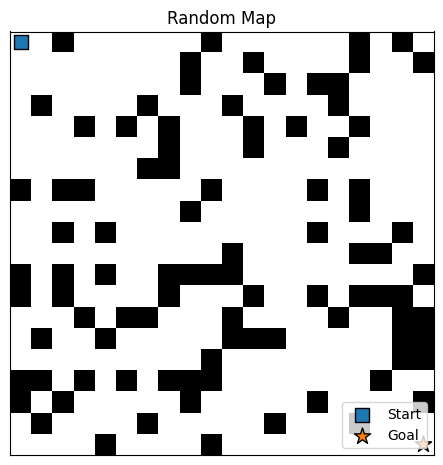

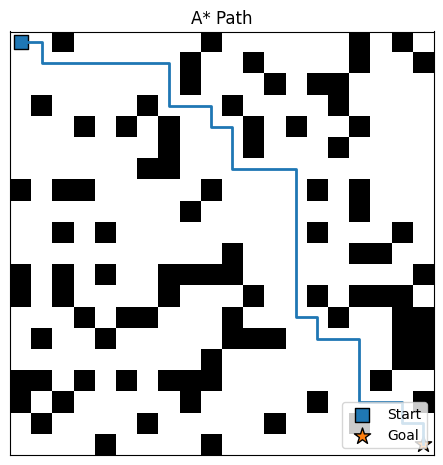

A* path length: 39
Ep 200: R=-104.0, steps=5, success=0, eps=0.367
Ep 400: R=-100.0, steps=1, success=0, eps=0.135
Ep 600: R=-136.0, steps=37, success=0, eps=0.050
Ep 800: R=-101.0, steps=2, success=0, eps=0.050
Ep 1000: R=-100.0, steps=1, success=0, eps=0.050
Ep 1200: R=-102.0, steps=3, success=0, eps=0.050
Ep 1400: R=-102.0, steps=3, success=0, eps=0.050
Ep 1600: R=-100.0, steps=1, success=0, eps=0.050
Ep 1800: R=-100.0, steps=1, success=0, eps=0.050
Ep 2000: R=-106.0, steps=7, success=0, eps=0.050
Success rate (last 200 eps): 0.0


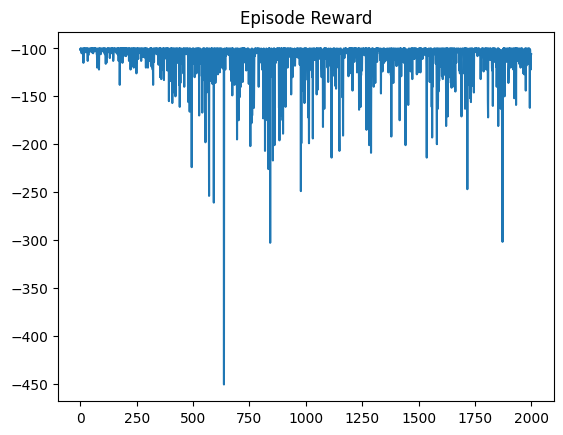

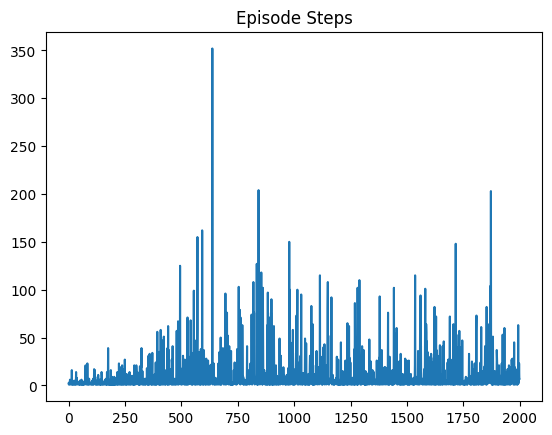

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- ENV ---
class GridWorld:
    def __init__(self, size=20, obstacle_prob=0.22, seed=42, terrain_cost=False):
        self.rng = np.random.default_rng(seed)
        self.size = size
        self.obstacle_prob = obstacle_prob
        self.terrain_cost = terrain_cost
        self.actions = {0:(-1,0), 1:(1,0), 2:(0,-1), 3:(0,1)}  # up, down, left, right
        self.reset()

    def _make_map(self):
        grid = (self.rng.random((self.size, self.size)) < self.obstacle_prob).astype(int)
        # ensure start/goal free
        grid[0,0] = 0
        grid[self.size-1, self.size-1] = 0
        return grid

    def reset(self):
        self.grid = self._make_map()
        self.start = (0,0)
        self.goal  = (self.size-1, self.size-1)
        self.pos = self.start
        self.steps = 0
        return self._state_id(self.pos)

    def _state_id(self, pos):
        return pos[0]*self.size + pos[1]

    def in_bounds(self, r, c):
        return 0 <= r < self.size and 0 <= c < self.size

    def free(self, r, c):
        return self.grid[r,c] == 0

    def step(self, a):
        dr, dc = self.actions[a]
        r, c = self.pos
        nr, nc = r + dr, c + dc

        reward = -1  # small step penalty
        done = False

        if not self.in_bounds(nr, nc) or not self.free(nr, nc):
            reward = -100  # collision
            done = True
            return self._state_id(self.pos), reward, done, {"reason": "collision"}

        self.pos = (nr, nc)
        self.steps += 1

        if self.pos == self.goal:
            reward = 100
            done = True

        return self._state_id(self.pos), reward, done, {}

    def neighbors(self, r, c):
        for dr, dc in self.actions.values():
            nr, nc = r+dr, c+dc
            if self.in_bounds(nr, nc) and self.free(nr, nc):
                yield (nr, nc)

    def render(self, path=None, title=""):
        img = np.copy(self.grid)
        # mark start/goal
        img[self.start] = 0
        img[self.goal] = 0
        plt.figure(figsize=(5.5,5.5))
        plt.imshow(img, cmap="Greys", origin="upper")
        plt.scatter([self.start[1]],[self.start[0]], marker="s", s=100, label="Start", edgecolors="k")
        plt.scatter([self.goal[1]],[self.goal[0]], marker="*", s=150, label="Goal", edgecolors="k")
        if path:
            ys = [p[0] for p in path]; xs = [p[1] for p in path]
            plt.plot(xs, ys, linewidth=2)
        plt.xticks([]); plt.yticks([]); plt.title(title); plt.legend(loc="lower right"); plt.show()

env = GridWorld(size=20, obstacle_prob=0.22, seed=1)
env.render(title="Random Map")

# A* part below

import heapq

def manhattan(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def astar_path(env: GridWorld):
    start, goal = env.start, env.goal
    pq = []
    heapq.heappush(pq, (0 + manhattan(start, goal), 0, start, None))
    came_from = {}
    g = {start: 0}
    visited = set()

    while pq:
        f, cost, node, parent = heapq.heappop(pq)
        if node in visited:
            continue
        visited.add(node)
        came_from[node] = parent

        if node == goal:
            # reconstruct
            path = []
            cur = node
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            path.reverse()
            return path

        for nbr in env.neighbors(*node):
            new_cost = cost + 1  # cost per move; extend later for terrain costs
            if nbr not in g or new_cost < g[nbr]:
                g[nbr] = new_cost
                fscore = new_cost + manhattan(nbr, goal)
                heapq.heappush(pq, (fscore, new_cost, nbr, node))

    return None  # no path

# Test on current map
path = astar_path(env)
env.render(path=path, title="A* Path" if path else "No Path Found")
print("A* path length:", len(path) if path else None)

# RL (Q-learning) below

class QAgent:
    def __init__(self, n_states, n_actions=4, alpha=0.1, gamma=0.99, epsilon=1.0, eps_min=0.05, eps_decay=0.995):
        self.Q = np.zeros((n_states, n_actions))
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_decay = eps_decay

    def act(self, s):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[s])

    def learn(self, s, a, r, s2, done):
        best_next = np.max(self.Q[s2]) if not done else 0
        td_target = r + self.gamma * best_next
        self.Q[s, a] += self.alpha * (td_target - self.Q[s, a])

    def decay(self):
        self.epsilon = max(self.eps_min, self.epsilon * self.eps_decay)

def train_q(env, episodes=2000, max_steps=400):
    agent = QAgent(n_states=env.size*env.size)
    rewards_hist, steps_hist, success_hist = [], [], []
    for ep in range(episodes):
        s = env.reset()
        total_r = 0; steps = 0; success = 0
        for t in range(max_steps):
            a = agent.act(s)
            s2, r, done, info = env.step(a)
            agent.learn(s, a, r, s2, done)
            total_r += r; steps += 1
            s = s2
            if done:
                success = 1 if r >= 100 else 0
                break
        agent.decay()
        rewards_hist.append(total_r)
        steps_hist.append(steps)
        success_hist.append(success)
        if (ep+1) % 200 == 0:
            print(f"Ep {ep+1}: R={total_r:.1f}, steps={steps}, success={success}, eps={agent.epsilon:.3f}")
    return agent, np.array(rewards_hist), np.array(steps_hist), np.array(success_hist)

agent, R, S, SUC = train_q(env, episodes=2000, max_steps=400)
print("Success rate (last 200 eps):", SUC[-200:].mean())
plt.figure(); plt.plot(R); plt.title("Episode Reward"); plt.show()
plt.figure(); plt.plot(S); plt.title("Episode Steps"); plt.show()

